<a href="https://colab.research.google.com/github/rudistiawannn/Ear-Disease-Clasification/blob/main/Search_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
import time
import joblib
import os

In [ ]:
def load_data():
    train_dir = '/content/drive/MyDrive/Ear Disease/Split Dataset/train'
    val_dir = '/content/drive/MyDrive/Ear Disease/Split Dataset/validation'

    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        image_size=(229, 229),
        batch_size=64,
        label_mode='categorical'
    )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        image_size=(229, 229),
        batch_size=64,
        label_mode='categorical'
    )

    # Mengubah normalisasi untuk rentang -1 hingga 1
    normalization_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)

    train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
    val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

    return train_dataset, val_dataset

In [ ]:
def create_model(params):
    base_model = Xception(include_top=False, input_shape=(229, 229, 3), weights='imagenet')
    base_model.trainable = False  # Freeze base model weights

    model = models.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(params['units'], activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(20, activation='softmax')
    ])

    return model

In [ ]:
space = [
    Integer(32, 256, name='units'),
    Real(0.2, 0.5, name='dropout_rate'),
    Real(1e-4, 1e-2, name='learning_rate', prior='log-uniform')
]

In [ ]:
@use_named_args(space)
def objective(**params):
    train_dataset, val_dataset = load_data()
    model = create_model(params)
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss=CategoricalCrossentropy(),
                  metrics=[CategoricalAccuracy()])
    start_time = time.time()
    history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, verbose=1)
    elapsed_time = time.time() - start_time
    val_accuracy = np.amax(history.history['val_categorical_accuracy'])
    return -val_accuracy  # Minimize negative accuracy

In [ ]:
def save_optimization_result(result, filename='optimization_result_xception.pkl', folder_path='/content/drive/MyDrive/Ear Disease/XceptionOptimizationResults'):
    # Pastikan folder ada
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Gabungkan path folder dengan nama file
    full_path = os.path.join(folder_path, filename)

    # Simpan hasil
    joblib.dump(result, full_path)
    print(f"Optimization result saved to {full_path}")

In [ ]:
result = gp_minimize(func=objective,
                     dimensions=space,
                     n_calls=50,
                     n_random_starts=10,
                     verbose=True)

save_optimization_result(result)

print("Best parameters:")
for name, value in zip(["units", "dropout_rate", "learning_rate"], result.x):
    print(f"{name}: {value}")

print(f"Best validation accuracy: {-result.fun}")

Iteration No: 1 started. Evaluating function at random point.
Found 836 files belonging to 20 classes.
Found 214 files belonging to 20 classes.
83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/10
14/14 [==============================] - 28s 1s/step - loss: 4.1545 - categorical_accuracy: 0.1411 - val_loss: 2.6499 - val_categorical_accuracy: 0.2103
Epoch 2/10
14/14 [==============================] - 19s 1s/step - loss: 2.3242 - categorical_accuracy: 0.3086 - val_loss: 2.2883 - val_categorical_accuracy: 0.3037
Epoch 3/10
14/14 [==============================] - 18s 1s/step - loss: 1.9863 - categorical_accuracy: 0.3816 - val_loss: 2.1334 - val_categorical_accuracy: 0.2804
Epoch 4/10
14/14 [==============================] - 18s 1s/step - loss: 1.7374 - categorical_accuracy: 0.4354 - val_loss: 2.0130 - val_categorical_accuracy: 0.3318
Epoch 5/10
14/14 [==============================] - 18s 1s/step - loss: 1.5554 - categorical_accuracy: 0.4916 - val_loss: 2.0467 - val_

In [ ]:
def plot_gp_1D(space, result, dim_idx, n_samples=100):
    X = np.array(result.x_iters)
    y = -np.array(result.func_vals)

    kernel = Matern(nu=2.5)
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp.fit(X, y)

    x = np.linspace(space[dim_idx].low, space[dim_idx].high, n_samples)
    X_plot = np.tile(result.x, (n_samples, 1))
    X_plot[:, dim_idx] = x

    mean, std = gp.predict(X_plot, return_std=True)

    plt.figure(figsize=(10, 6))
    plt.plot(X[:, dim_idx], y, 'r.', markersize=10, label='Observations')
    plt.plot(x, mean, 'b-', label='Posterior Mean')
    plt.fill_between(x, mean - 1.96 * std, mean + 1.96 * std, alpha=0.2)
    plt.xlabel(space[dim_idx].name)
    plt.ylabel('Validation Accuracy')
    plt.title(f'GP Posterior for {space[dim_idx].name}')
    plt.legend()
    plt.show()

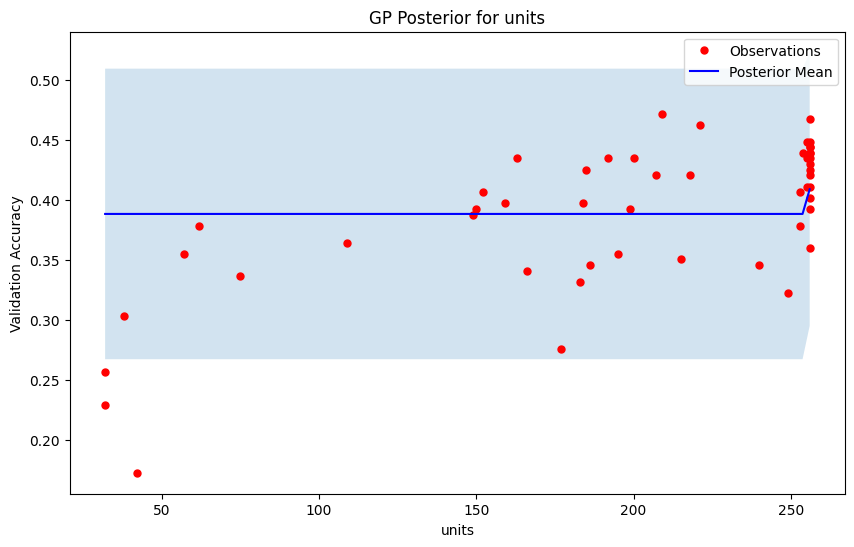

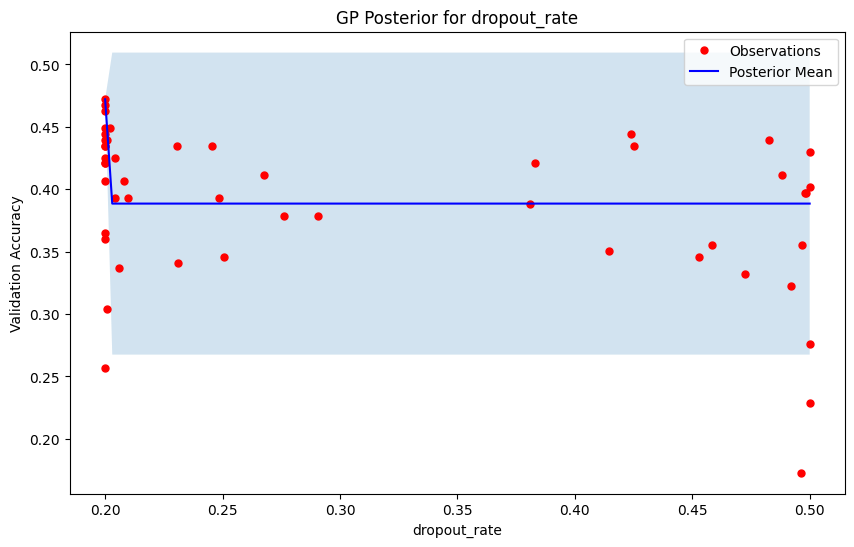

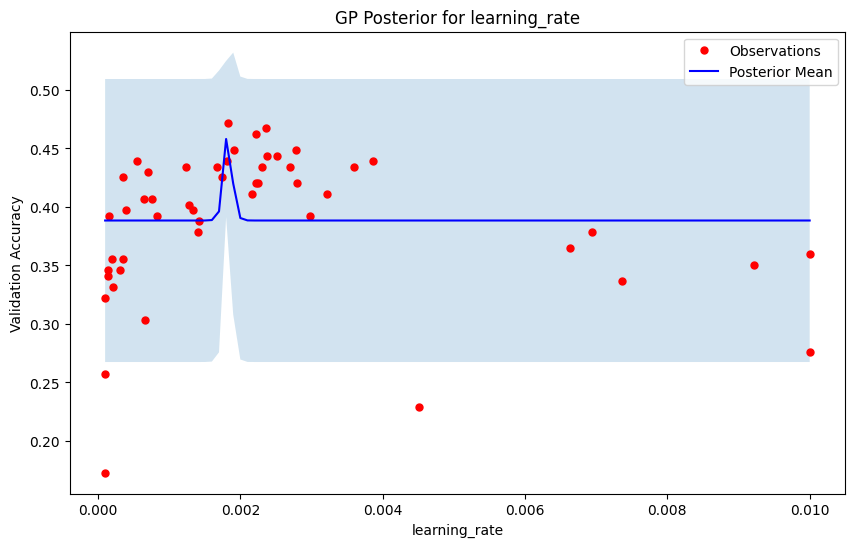

In [ ]:
for i in range(len(space)):
    plot_gp_1D(space, result, i)